In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        # self.fc2 = nn.Linear(50, 10)
        self.mean = nn.Linear(50, 3)
        self.sigma = nn.Linear(50, 3)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        #x = self.fc2(x)
        mean = self.mean(x)
        sigma = self.sigma(x)
        #return mean, sigma
        mean = mean / (10 + mean.norm(dim=1, keepdim=True)).sqrt()
        sigma = sigma / (10 + sigma.norm(dim=1, keepdim=True)).sqrt()
        return mean , sigma

In [4]:
device = torch.device("cuda")

In [5]:
kwargs = {'num_workers': 1, 'pin_memory': True}

In [8]:
b_size = 4098
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=b_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=b_size, shuffle=True, **kwargs)

In [7]:
model = Net().to(device)

In [8]:
optimizer = optim.RMSprop(model.parameters(), lr=1e-5, momentum=0.99)

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
def plot_clusters(nodes_predictions, true_labels, azim=47, elev=30):
    nodes_predictions = np.array(nodes_predictions[0].detach())
    true_labels = np.array(true_labels)
    
    
    fig = plt.figure(figsize=(12, 12))
    ax = fig.gca(projection='3d')
    ax.view_init(azim=azim, elev=elev)
    for cluster_id in np.unique(true_labels):
        if cluster_id == 0.:
            continue
        l = len(nodes_predictions[true_labels==cluster_id, 0])
        ax.scatter(
            nodes_predictions[true_labels==cluster_id, 0],
            nodes_predictions[true_labels==cluster_id, 1],
            nodes_predictions[true_labels==cluster_id, 2],
            alpha=0.4
        )
        
    plt.show()

In [10]:
optimizer.param_groups[0]['lr'] = 1e-5

In [11]:
def pairwise_distances(x, y = None):
    x_norm = (x**2).sum(1).view(-1, 1)
    if y is not None:
        y_t = torch.transpose(y, 0, 1)
        y_norm = (y**2).sum(1).view(1, -1)
    else:
        y_t = torch.transpose(x, 0, 1)
        y_norm = x_norm.view(1, -1)
    
    dist = x_norm + y_norm - 2.0 * torch.mm(x, y_t)
    # Ensure diagonal is zero if x=y
    # if y is None:
    #     dist = dist - torch.diag(dist.diag)
    return torch.clamp(dist, 0.0, np.inf)

In [12]:
def make_contrastive_loss(nodes_predictions, true_labels, margin=1., **kwargs):
    nodes_predictions = nodes_predictions[0]
    loss = 0.
    p = pairwise_distances(nodes_predictions)
    unique_labels = np.unique(true_labels).astype(float)
    N = len(output[0])
    for i in range(len(unique_labels)):
        if unique_labels[i] in [6, 7, 8, 9]:
            continue
        for j in range(i + 1):
            if unique_labels[j] in [6, 7, 8, 9]:
                continue
            if i == j:
                loss = loss + p[true_labels == unique_labels[i]][:, true_labels == unique_labels[j]].sum()
            else:
                loss = loss + torch.relu(margin - (1e-4 + p[true_labels == unique_labels[i]][:, true_labels == unique_labels[j]]).sqrt()).pow(2).sum()
                

                    
    return loss / (N * (N - 1))

In [13]:
import time
import numpy as np

Train Epoch: 173 0 [0/60000 (0%)]	Loss: 0.010322


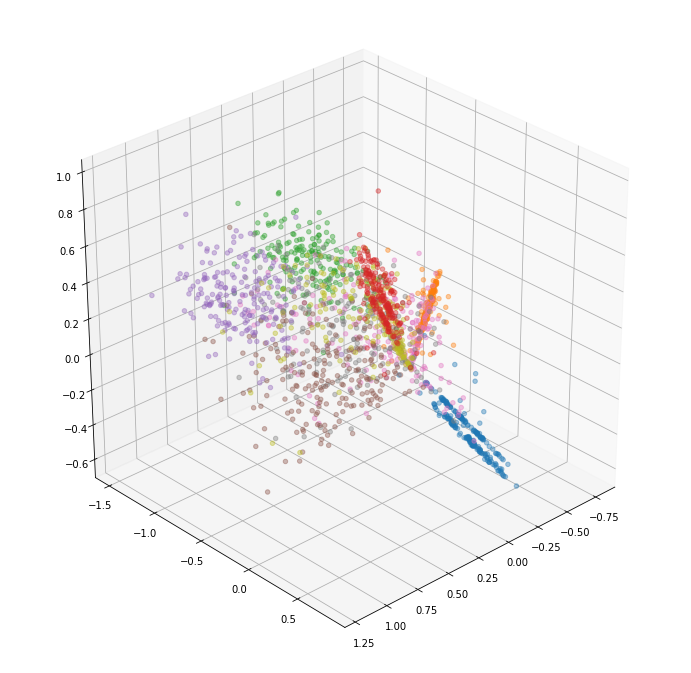

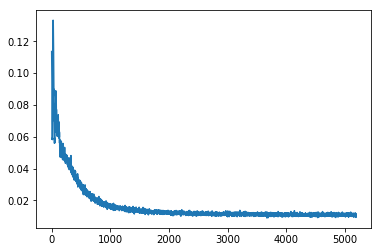

In [ ]:
from IPython.display import clear_output
from tqdm import tqdm
model.train()
losses_sim = []
losses_dist = []
losses = []
times = []
start = time.time()
for i in tqdm(range(1000)):
    times.append(time.time() - start)
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        
        loss = make_contrastive_loss(output, target)
        
        loss.backward()

        losses.append(loss.item())
        if batch_idx % 20 == 0:
            clear_output()
            print('Train Epoch: {} {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                  i, batch_idx, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item())
                 )
            plot_clusters(output, target)
            
            plt.plot(losses)
            plt.show()
        
        optimizer.step()

In [19]:
X = []
Y = []

Train Epoch: 0 [0/10000 (0%)]	


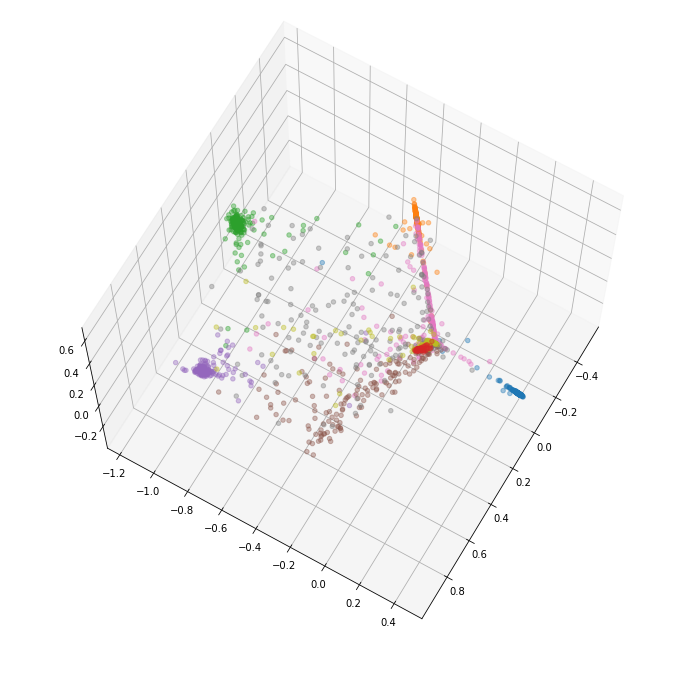

Train Epoch: 1 [2048/10000 (3%)]	


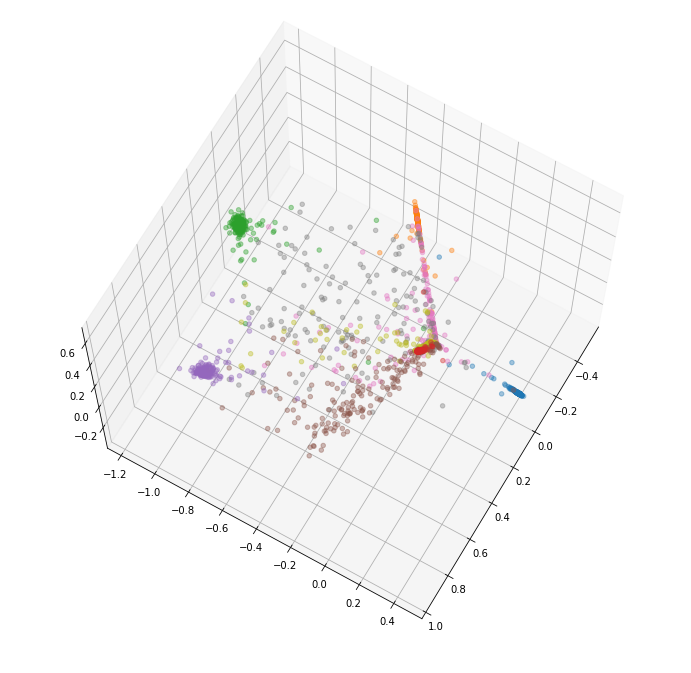

Train Epoch: 2 [4096/10000 (7%)]	


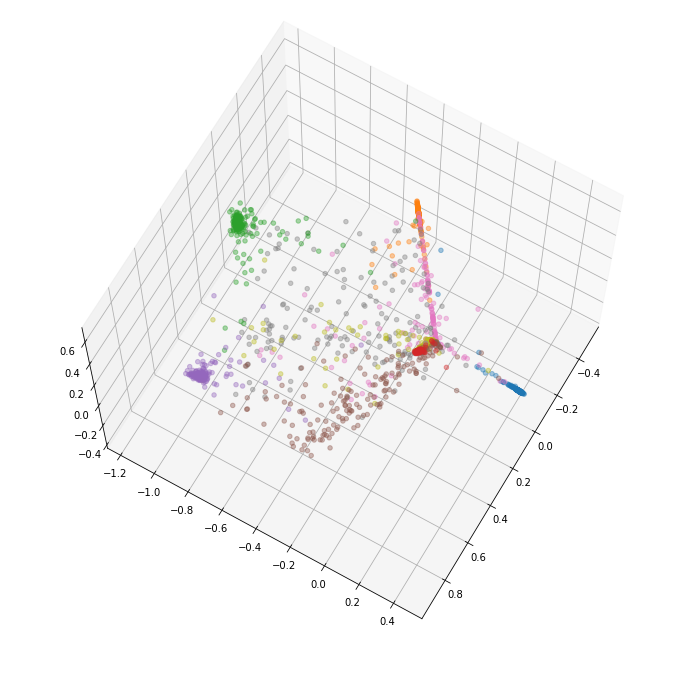

Train Epoch: 3 [6144/10000 (10%)]	


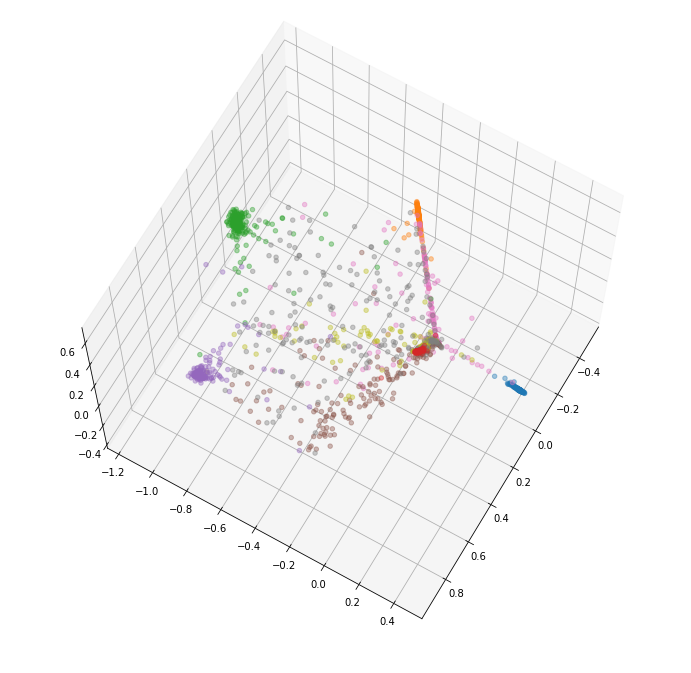

Train Epoch: 4 [7232/10000 (13%)]	


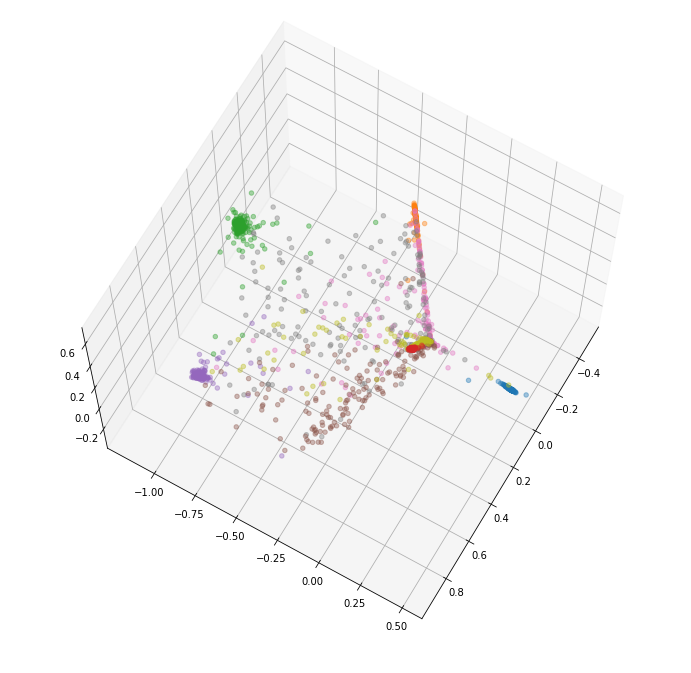

In [20]:
model.train(False)
for batch_idx, (data, target) in enumerate(test_loader):
    data, target = data.to(device), target.to(device)
    output = model(data)
    X.append(output[0].cpu().detach().numpy())
    Y.append(target.cpu().detach().numpy())
    print('Train Epoch: {} [{}/{} ({:.0f}%)]\t'.format(
          batch_idx, batch_idx * len(data), len(test_loader.dataset),
100. * batch_idx / len(train_loader))
         )
    plot_clusters(output, target, azim=30, elev=70)

In [21]:
X = np.concatenate(X)

In [22]:
Y = np.concatenate(Y)

In [23]:
from time import time

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

from sklearn import manifold
from sklearn.utils import check_random_state

N = 500

# Perform t-distributed stochastic neighbor embedding.
t0 = time()
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
trans_data = tsne.fit_transform(X[:N]).T
t1 = time()
print("t-SNE: %.2g sec" % (t1 - t0))

t-SNE: 16 sec


In [24]:
colors = Y[:N]

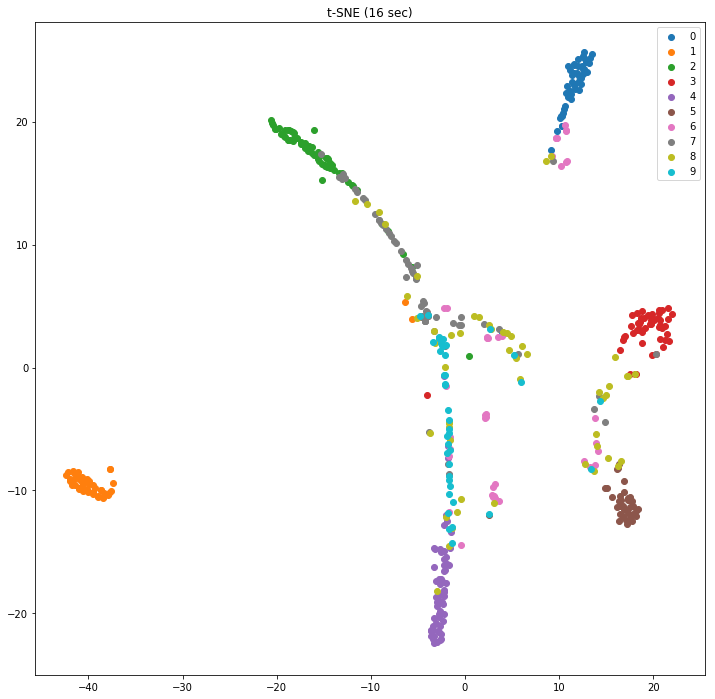

In [25]:
plt.figure(figsize=(12, 12))
for color in np.unique(colors):
    plt.scatter(trans_data[0][colors == color], trans_data[1][colors == color], cmap=plt.cm.rainbow, label=color)
plt.title("t-SNE (%.2g sec)" % (t1 - t0))
plt.axis('tight')
plt.legend()
plt.show()

In [26]:
def plot_clusters_np(nodes_predictions, true_labels, azim=47, elev=30):
    
    fig = plt.figure(figsize=(12, 12))
    ax = fig.gca(projection='3d')
    ax.view_init(azim=azim, elev=elev)
    for cluster_id in np.unique(true_labels):
        if cluster_id == 0.:
            continue
        l = len(nodes_predictions[true_labels==cluster_id, 0])
        ax.scatter(
            nodes_predictions[true_labels==cluster_id, 0],
            nodes_predictions[true_labels==cluster_id, 1],
            nodes_predictions[true_labels==cluster_id, 2],
            alpha=0.4
        )
        
    plt.show()

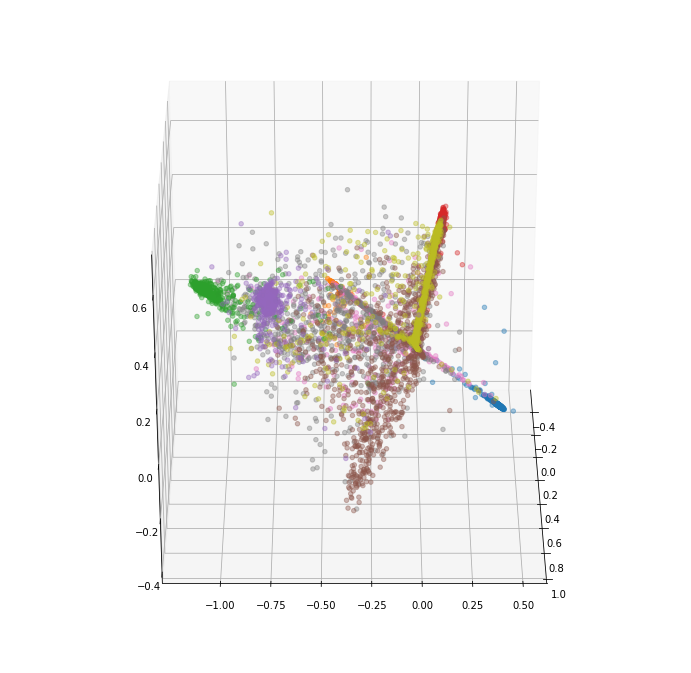

In [27]:
plot_clusters_np(X, Y, azim=0)

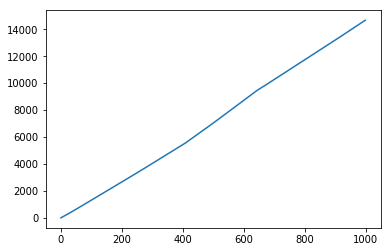

In [28]:
plt.plot(times)

In [25]:
times

[0.0023550987243652344,
 15.112437963485718,
 27.420084714889526,
 39.729310035705566,
 53.24923586845398,
 66.7754693031311,
 79.5514018535614,
 93.31049084663391,
 106.57923650741577,
 119.15201115608215,
 132.20826172828674,
 145.34787440299988,
 158.77777886390686,
 171.80388116836548,
 184.30366921424866,
 197.515150308609,
 210.7238175868988,
 223.3551094532013,
 236.40338897705078,
 250.34747076034546,
 263.67708230018616,
 276.6142156124115,
 289.8206810951233,
 303.1803960800171,
 315.71145129203796,
 328.40130043029785,
 341.0476927757263,
 354.71243929862976,
 368.6346278190613,
 382.40638184547424,
 394.8955478668213,
 408.45519638061523,
 420.9632430076599,
 433.77592182159424,
 446.64740443229675,
 459.7357120513916,
 473.01487922668457,
 485.9590082168579,
 498.5174674987793,
 511.1248335838318,
 523.9883227348328,
 537.3693046569824,
 550.4113702774048,
 563.2662947177887,
 577.2906265258789,
 590.1117753982544,
 602.9882357120514,
 616.0362620353699,
 629.6270513534546